<a href="https://colab.research.google.com/github/AsmatZahra/Advanced-Computer-Vision/blob/master/U_Net_MonuSeg_Dataset_w_o_DataGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/acv assignments/assignment 3/

/content/drive/My Drive/Colab Notebooks/acv assignments/assignment 3


In [0]:
!ls

In [4]:
#Required imports
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x
TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#Set some parameters
Orig_img_width = 1000
Orig_img_height = 1000

patch_img_width= 256
patch_img_height=256
no_of_channels= 1

path_train_images= "MonuSegForGenerator3/Training/TissueImages/"
path_train_groundtruth= "MonuSegForGenerator3/Training/GroundTruths/"


In [60]:
#Setting path to dataset
ids = next(os.walk(path_train_images))[2] # list of names all images in the given path
ids_groundTruth= next(os.walk(path_train_groundtruth))[2]
print("No. of images = ", len(ids))
print("No. of images_GroundTruth = ", len(ids_groundTruth))

No. of images =  1920
No. of images_GroundTruth =  1920


In [61]:
# To receive train images in X and Y
X = np.zeros((1920, 256,256,1), dtype=np.float32)
Y = np.zeros((1920, 256,256,1), dtype=np.float32)
print ("Shape of X is:",X.shape)
print ("Shape of y is:", Y.shape)

Shape of X is: (1920, 256, 256, 1)
Shape of y is: (1920, 256, 256, 1)


In [62]:
# Loading image and converting to array then reshaping and saving in X(tissue images) and  Y(ground truths)
#tqdm is used to display the progress bar
for n, ids_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(path_train_images+ids_, grayscale=True)
    x_img = img_to_array(img)
    x_img= np.reshape(x_img,(patch_img_height,patch_img_width,no_of_channels))
    # Load masks
    mask = img_to_array(load_img(path_train_groundtruth+ids_, grayscale=True))
    mask= np.reshape(mask,(patch_img_height,patch_img_width,no_of_channels))  
    X[n] = x_img/255.0
    Y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Text(0.5, 1.0, 'GroundTruth')

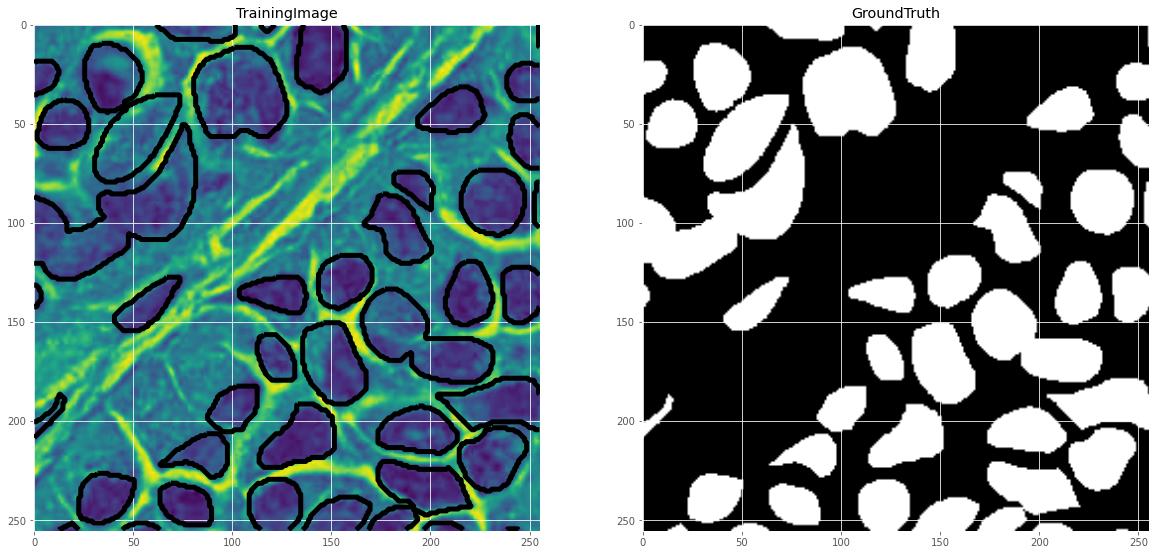

In [63]:
# Visualize any randome image along with the mask
ix=random.randint(0, len(X))
has_mask = Y[ix].max() > 0 # nuclie indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if  nucliea draw a boundary(contour) in the original image separating infected and non-infected areas
    ax1.contour(Y[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TrainingImage')

ax2.imshow(Y[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

U-Net Architecture

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [68]:
# Model Compilation
input_img = Input((patch_img_height, patch_img_width, no_of_channels), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=(["accuracy", "mse"]))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 256, 256, 16) 64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 256, 256, 16) 0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [73]:
#Setting some parameter for model evaluation
EPOCHS=50
BATCH_SIZE= 32
STEPS_PER_EPOCH = np.ceil(len(ids)/BATCH_SIZE)
print ("steps per epoch: ", STEPS_PER_EPOCH)

steps per epoch:  60.0


In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-withoutGenerator-Largemonuseg.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

In [76]:
results = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 1728 samples, validate on 192 samples
Epoch 1/50
1728/1728 [==============================] - 31s 18ms/step - loss: 0.3937 - accuracy: 0.8369 - mse: 0.1212 - val_loss: 0.6530 - val_accuracy: 0.7306 - val_mse: 0.2160

Epoch 00001: val_loss improved from inf to 0.65299, saving model to model-withoutGenerator-Largemonuseg.h5
Epoch 2/50
1728/1728 [==============================] - 29s 17ms/step - loss: 0.3183 - accuracy: 0.8697 - mse: 0.0956 - val_loss: 0.8535 - val_accuracy: 0.7306 - val_mse: 0.2444

Epoch 00002: val_loss did not improve from 0.65299
Epoch 3/50
1728/1728 [==============================] - 29s 17ms/step - loss: 0.2984 - accuracy: 0.8761 - mse: 0.0902 - val_loss: 1.1106 - val_accuracy: 0.7307 - val_mse: 0.2586

Epoch 00003: val_loss did not improve from 0.65299
Epoch 4/50
1728/1728 [==============================] - 29s 17ms/step - loss: 0.2812 - accuracy: 0.8833 - mse: 0.0851 - val_loss: 1.0975 - val_accuracy: 0.7321 - val_mse: 0.2537

Epoch 00004: val_loss did no

In [77]:
print(results.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'val_mse', 'loss', 'accuracy', 'mse', 'lr'])


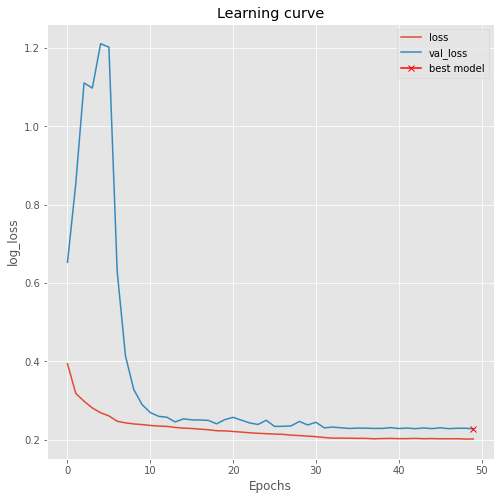

In [78]:
#plotting Larning curve / loss ratio
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

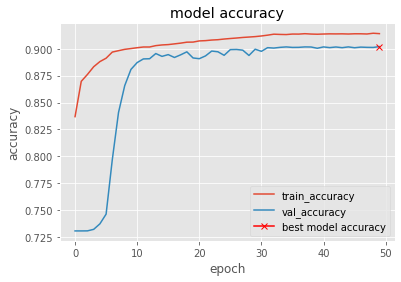

In [79]:
# summarize history for accuracy
plt.plot(results.history['accuracy'], label='train_accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.legend();

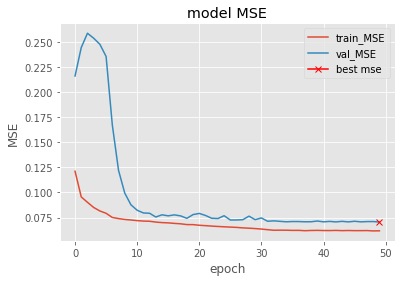

In [82]:
# summarize history for MSE
plt.plot(results.history['mse'], label='train_MSE')
plt.plot(results.history['val_mse'], label = 'val_MSE')
plt.plot( np.argmin(results.history["val_mse"]), np.min(results.history["val_mse"]), marker="x", color="r", label="best mse")
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.legend();

In [0]:
# load the best model
model.load_weights('model-withoutGenerator-Largemonuseg.h5')

In [89]:
# Evaluate on validation set (this must be equals to the best log_loss)
score= model.evaluate(X_valid, y_valid, verbose=1)
print("Loss score on best model: ",score[0])
print("Accuracy score on best model: ",score[1])
print("MSE score on best model: ",score[2])

192/192 [==============================] - 1s 5ms/step
Loss score on best model:  0.2278953343629837
Accuracy score on best model:  0.902019739151001
MSE score on best model:  0.0705433040857315


working on test set

In [91]:
# Setting some parameters for test set
path_test_images= "MonuSegForGenerator3/Test/TissueImages/"
path_test_groundtruth= "MonuSegForGenerator3/Test/GroundTruths/"

ids_test_img= next(os.walk(path_test_images))[2] # list of names all images in the given path
ids_test_mask= next(os.walk(path_test_groundtruth))[2]
print("No. of test images = ", len(ids_test_img))
print("No. of test_GroundTruth = ", len(ids_test_mask))

No. of test images =  14
No. of test_GroundTruth =  14


In [92]:
# To receive test images
X_test = np.zeros((14, 256,256,1), dtype=np.float32)
Y_test = np.zeros((14, 256,256,1), dtype=np.float32)
print ("Shape of Xs is:",X_test.shape)
print ("Shape of ys is:", Y_test.shape)

Shape of Xs is: (14, 256, 256, 1)
Shape of ys is: (14, 256, 256, 1)


In [93]:
# Loading test images and converting to array then reshaping and saving in X(tissue images) and  Y(ground truths)
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test_img), total=len(ids_test_img)):
    # Load images
    img = load_img(path_test_images+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (patch_img_height, patch_img_width, no_of_channels), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_= id_[:-4]+"_bin_mask.png"
    mask = load_img(path_test_groundtruth + mask_id_, grayscale=True) 
    mask = img_to_array(mask)
    mask = resize(mask, (patch_img_height, patch_img_width, no_of_channels), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    Y_test[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [96]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 0s 5ms/step


In [100]:
(preds_test.shape)

(14, 256, 256, 1)

In [0]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [104]:
print("IOU: " , iou_coef(Y_test, preds_test))
print("Dice: " , dice_coef(Y_test, preds_test))

IOU:  Tensor("Mean_7:0", shape=(), dtype=float32)
Dice:  Tensor("Mean_8:0", shape=(), dtype=float32)


In [105]:
from sklearn.metrics import classification_report, confusion_matrix
TN, FP, FN, TP = confusion_matrix(Y_test.flatten().astype(int),
                             preds_test.round(0).flatten().astype(int)).ravel()

print ("Accuracy:", round((TP+TN)/(TP+FP+TN+FN), 4))

print ("\n",classification_report(Y_test.round(0).flatten().astype(int), preds_test.round(0).flatten().astype(int)))

Accuracy: 0.816

               precision    recall  f1-score   support

           0       0.90      0.90      0.90    739022
           1       0.57      0.58      0.58    178482

    accuracy                           0.83    917504
   macro avg       0.74      0.74      0.74    917504
weighted avg       0.84      0.83      0.83    917504



In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    #ax[0].imshow(X[ix, ..., 0])
    ax[0].imshow(X[ix, ..., 0])

    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('GroundTruth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted superimposed on original');

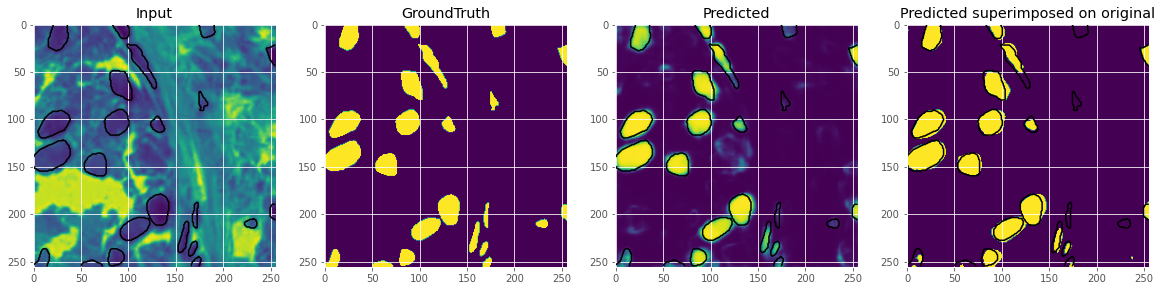

In [110]:
# Check if training data looks all right
ix=random.randint(0, len(X_train))
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=ix)

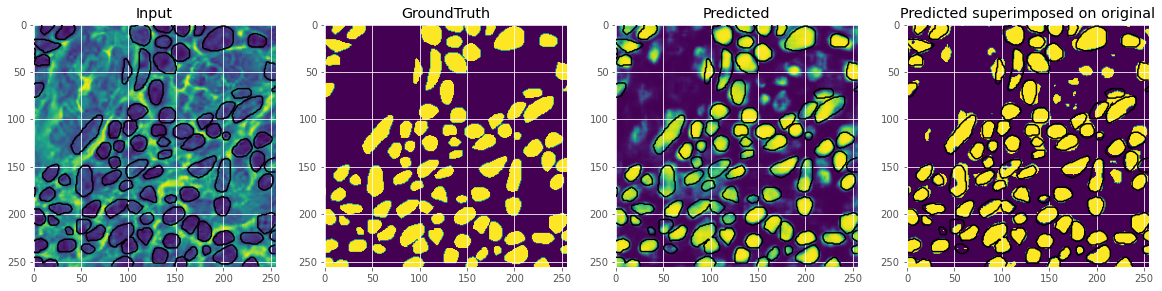

In [111]:
# Check if valid data looks all right
ix=random.randint(0, len(X_valid))
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1 )

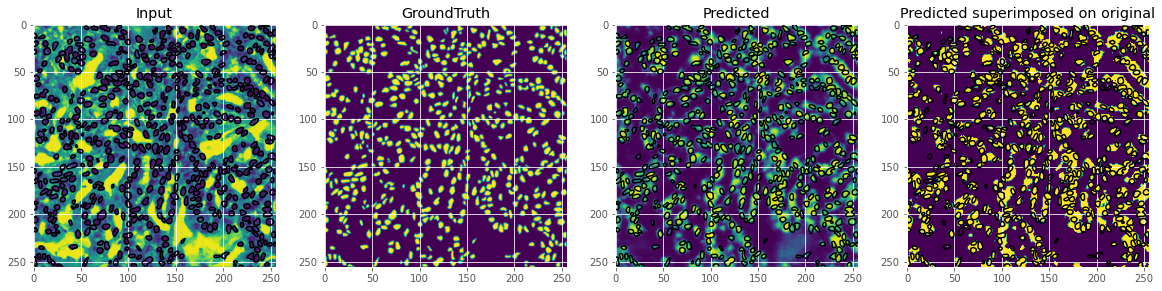

In [114]:
# Check if test data looks all right
ix=random.randint(0, len(X_test))
plot_sample(X_test,Y_test, preds_test, preds_test_t,ix=0 )